## Experimenting with the ECDC COVID-19 Data

J. Colliander  
2020-03-24

In [ ]:
# !pip install plotly
# !pip install chart_studio

In [5]:
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns 
DATE = datetime.today()
DATE_STR = DATE.strftime('%Y-%m-%d')
BASE_URL = f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{DATE_STR}.xlsx'
print(f'Downloading for {DATE_STR}')
while True:
    try:
        BASE_URL = f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{DATE_STR}.xlsx'
        data_world = pd.read_excel(BASE_URL)
        print('Success!')
        break
    except:
        print(f'Couldn\’t get data for {DATE_STR}, trying a day before…')
        # subtract a day
        DATE = DATE - timedelta(days=1)
        DATE_STR = DATE.strftime('%Y-%m-%d')

Success!


In [6]:
# some preprocessing
# change column names
data_world.rename(columns={'DateRep':'datestr','Countries and territories':'country', 'Cases':'cases', 'Deaths':'deaths', 'GeoId':'geoid'},
inplace=True)# convert dates
data_world['date'] = pd.to_datetime(data_world.datestr, format= "%Y-%m-%d")# remove unnecessary columns 
data_world.drop('Day', axis=1, inplace=True)
data_world.drop('Month', axis=1, inplace=True)
data_world.drop('Year', axis=1, inplace=True)
data_world.drop('datestr', axis=1, inplace=True)# set date as index
data_world = data_world.set_index('date').sort_index()# calculate cases for the whole world
total = data_world.groupby('date').sum()
# add columns and add to full dataframe
total['geoid'] = 'W'
total['country'] = 'World'
#total['datestr'] = total.index.astype('str')
total.reset_index()
data_world = data_world.append(total, sort=False)# calculate cases for world outside China
total_outcn = data_world.query("geoid not in ['W', 'CN']").groupby('date').sum()
# add columns and add to full dataframe
total_outcn['geoid'] = 'OUTC'
total_outcn['country'] = 'OutsideC'
#total['datestr'] = total.index.astype('str')
total_outcn.reset_index()
data_world = data_world.append(total_outcn, sort=False)# calculate cumulative sum for each country
data_world['cases_cum'] = data_world.groupby(['country'])['cases'].cumsum()
data_world['deaths_cum'] = data_world.groupby(['country'])['deaths'].cumsum()

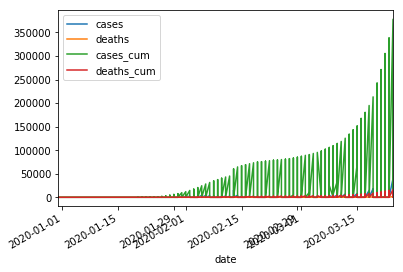

In [7]:
data_world.plot()

Yay! I've implemented the Medium article. 2020-03-24, 9:26pm.

In [8]:
## Identify programs that have received the most funding
pd.pivot_table(data_world, index=['country'], aggfunc=max,
               values = ['cases_cum', 'deaths_cum']
              ).sort_values(by=['cases_cum'], ascending=False)

,cases_cum,deaths_cum
country,,
World,378041,16365
OutsideC,296293,13082
China,81748,3283
Italy,63927,6077
United_States_of_America,46442,590
Spain,33089,2182
Germany,29212,126
Iran,23049,1812
France,19856,860


In [9]:
COUNTRY = 'Italy'

In [10]:
local = data_world.loc[(data_world['country'] == COUNTRY)]

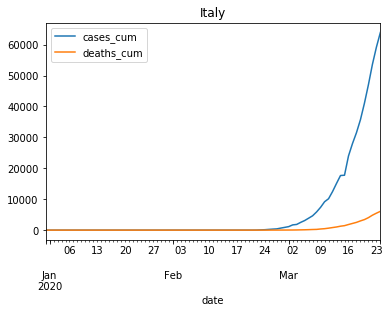

In [11]:
local[['cases_cum', 'deaths_cum']].plot(title = COUNTRY)

In [12]:
Comparisons = ['Canada', 'United_States_of_America', 'France', 'Germany', 'South_Korea', 'China']

In [36]:
subset = data_world.loc[(data_world['country'].isin(Comparisons))]

In [114]:
# df.groupby(['FiscalYear']).sum()['AwardAmount'].plot(kind="bar", title="Total Expenditures vs. Time"))

country
Canada                         AxesSubplot(0.125,0.2;0.775x0.68)
China                       AxesSubplot(0.125,0.125;0.775x0.755)
France                      AxesSubplot(0.125,0.125;0.775x0.755)
Germany                     AxesSubplot(0.125,0.125;0.775x0.755)
South_Korea                 AxesSubplot(0.125,0.125;0.775x0.755)
United_States_of_America    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

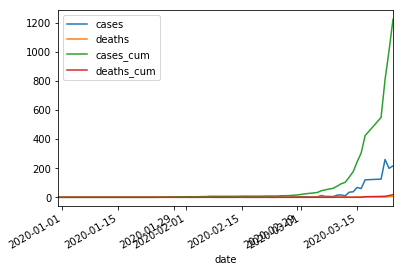

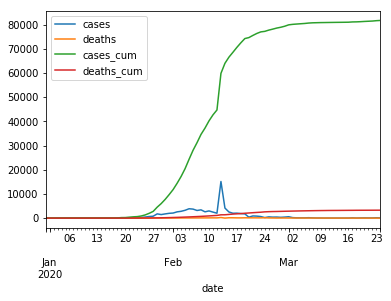

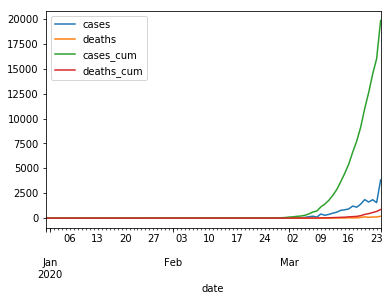

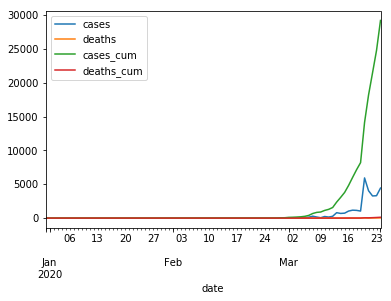

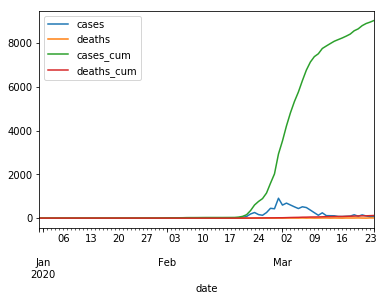

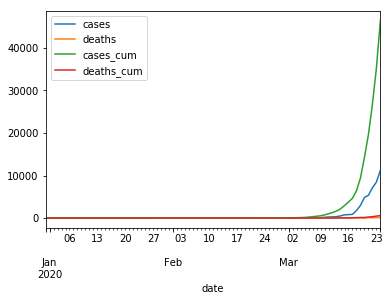

In [40]:
subset.groupby('country').plot()

In [ ]:
# (disc.groupby(['ProgramNameEN','FiscalYear']).sum()
#  ['AwardAmount'].unstack()).plot(
#    kind="bar", stacked=False, cmap="viridis", alpha=0.7, figsize=(16, 8), width=1, 
#    title="Total dollars invested by Evaluation Group Committee")

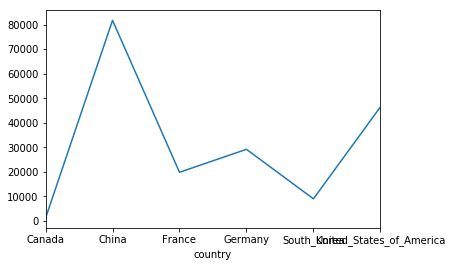

In [53]:
(subset.groupby(['country']).sum()['cases']).plot()

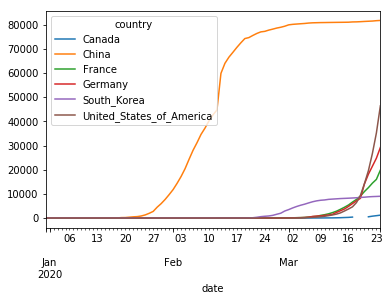

In [60]:
subset.pivot(columns="country", values="cases_cum").plot()

In [59]:
subset.columns

Index(['cases', 'deaths', 'country', 'geoid', 'cases_cum', 'deaths_cum'], dtype='object')